In [64]:
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [42]:
data = pd.read_csv("../data/abalone.csv")
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [44]:
data.shape

(4177, 9)

In [45]:
data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [47]:
X = data.drop(columns=["Rings"])
y = data["Rings"]

In [48]:
X["Sex"].value_counts()

M    1447
I    1276
F    1259
f     195
Name: Sex, dtype: int64

Очевидно имеется опечатка, необходимо f заменить на F.

In [49]:
X["Sex"] = X["Sex"].replace("f", "F")

Посмотрим сначала на значения целевой переменной.

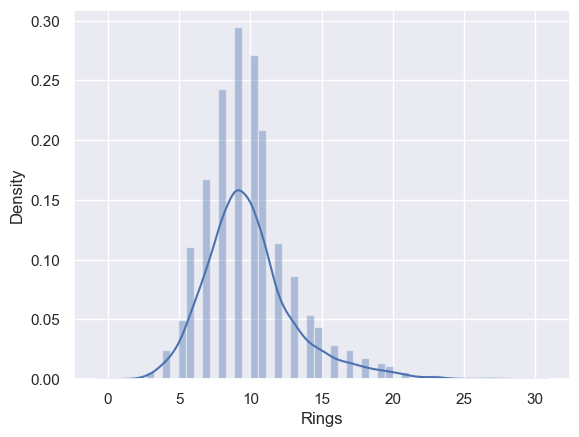

In [50]:
sns.distplot(y);

Заполним пропуски в признаках в зависимости от пола.

In [51]:
cols = ["Diameter", "Whole weight", "Shell weight"]
for col in cols:
    X.loc[X["Sex"] == "M", col] = X[X["Sex"] == "M"][col].fillna(X[X["Sex"] == "M"][col].mean())
    X.loc[X["Sex"] == "F", col] = X[X["Sex"] == "F"][col].fillna(X[X["Sex"] == "F"][col].mean())
    X.loc[X["Sex"] == "I", col] = X[X["Sex"] == "I"][col].fillna(X[X["Sex"] == "I"][col].mean())

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
dtypes: float64(7), object(1)
memory usage: 261.2+ KB


Посмотрим на распределения признаков.

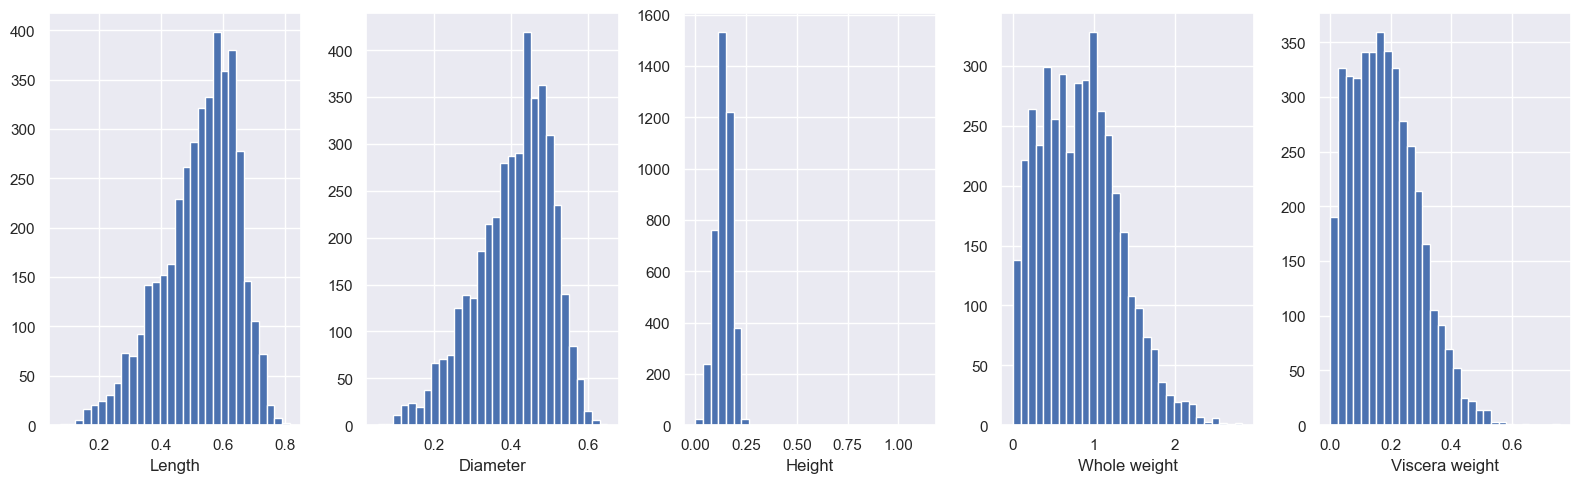

In [54]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=5)
for i, feature in enumerate(["Length", "Diameter", "Height", "Whole weight", "Viscera weight"]):
    axs[i].hist(X[feature].values, bins=30)
    axs[i].set_xlabel(feature)
plt.tight_layout()

Прологарифмируем признак *Height*

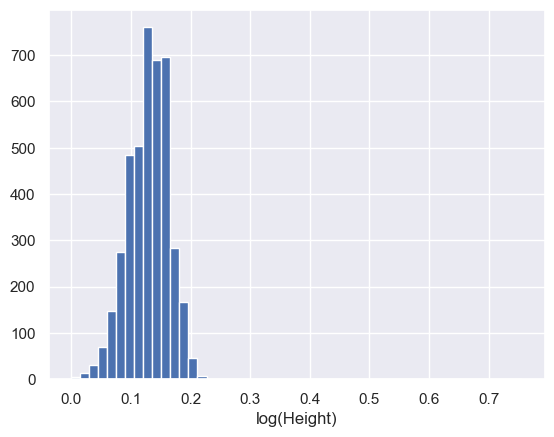

In [58]:
X["log_Height"] = np.log1p(X["Height"].values)
plt.hist(X["log_Height"].values, bins=50)
plt.xlabel("log(Height)")
plt.show()

Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки

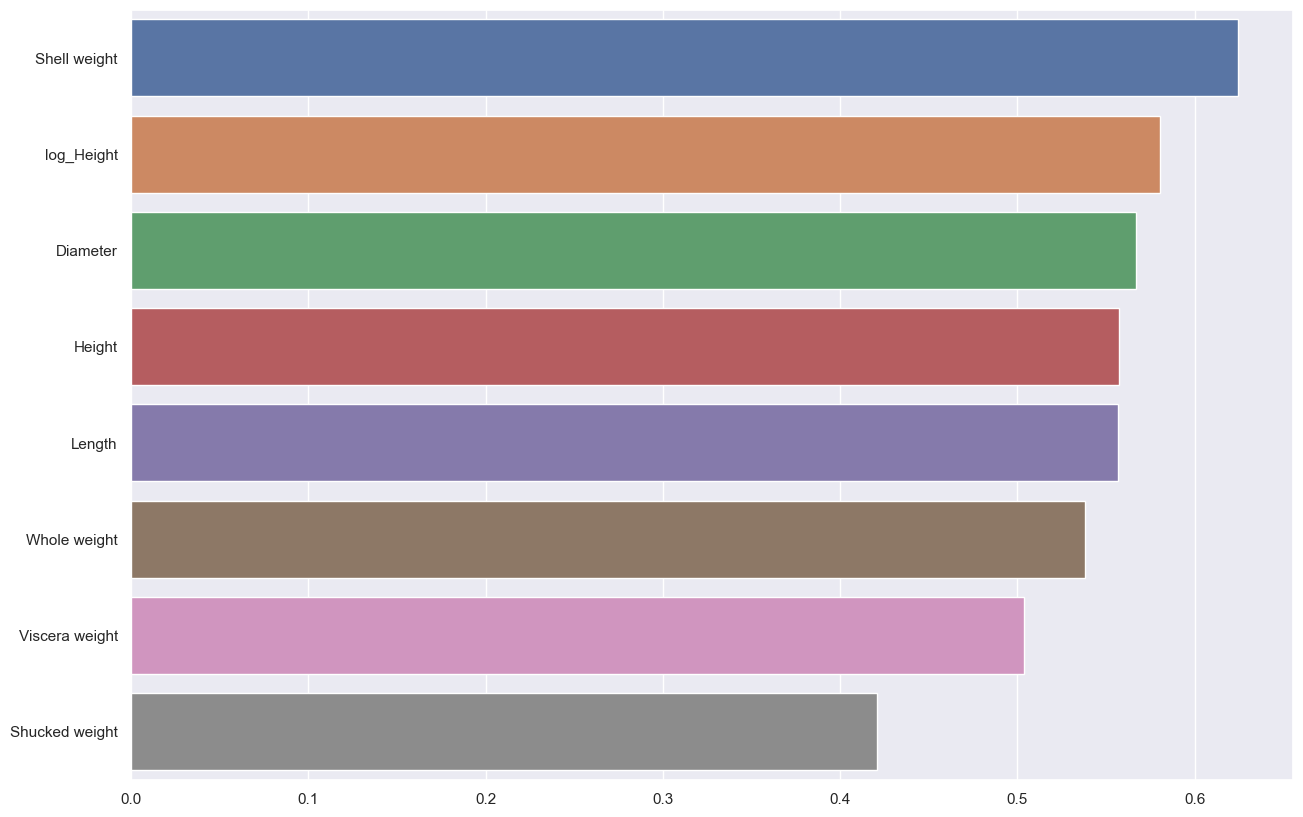

In [59]:
numeric_data = X.select_dtypes([np.number])
numeric_features = numeric_data.columns

correlations = X[numeric_features].corrwith(y).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Удалим колонку *Height*, оставив только ее логарифм

In [60]:
X = X.drop(columns=["Height"])

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет.

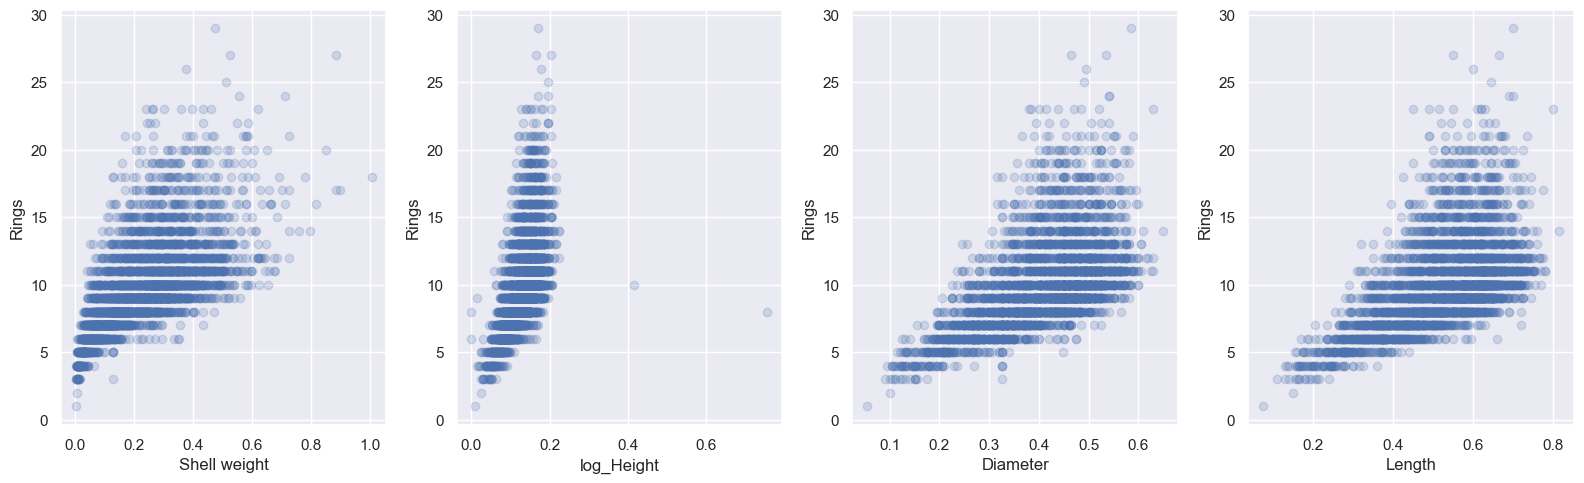

In [63]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=4)
for i, feature in enumerate(["Shell weight", "log_Height", "Diameter", "Length"]):
    axs[i].scatter(X[feature], y, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Rings")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

Проверим корреляцию между признаками.

In [66]:
Data = []

for c1 in X.columns:
    for c2 in X.columns:
        if X[c1].dtype == 'object' and X[c2].dtype != 'object':
            CategoryGroupLists = X.groupby(c1)[c2].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            if AnovaResults[1] >= 0.05:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'No'})
            else:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'Yes'})

AnovaRes = pd.DataFrame.from_dict(Data)
AnovaRes

,Category,Numerical,Is correlated
0,Sex,Length,Yes
1,Sex,Diameter,Yes
2,Sex,Whole weight,Yes
3,Sex,Shucked weight,Yes
4,Sex,Viscera weight,Yes
5,Sex,Shell weight,Yes
6,Sex,log_Height,Yes
